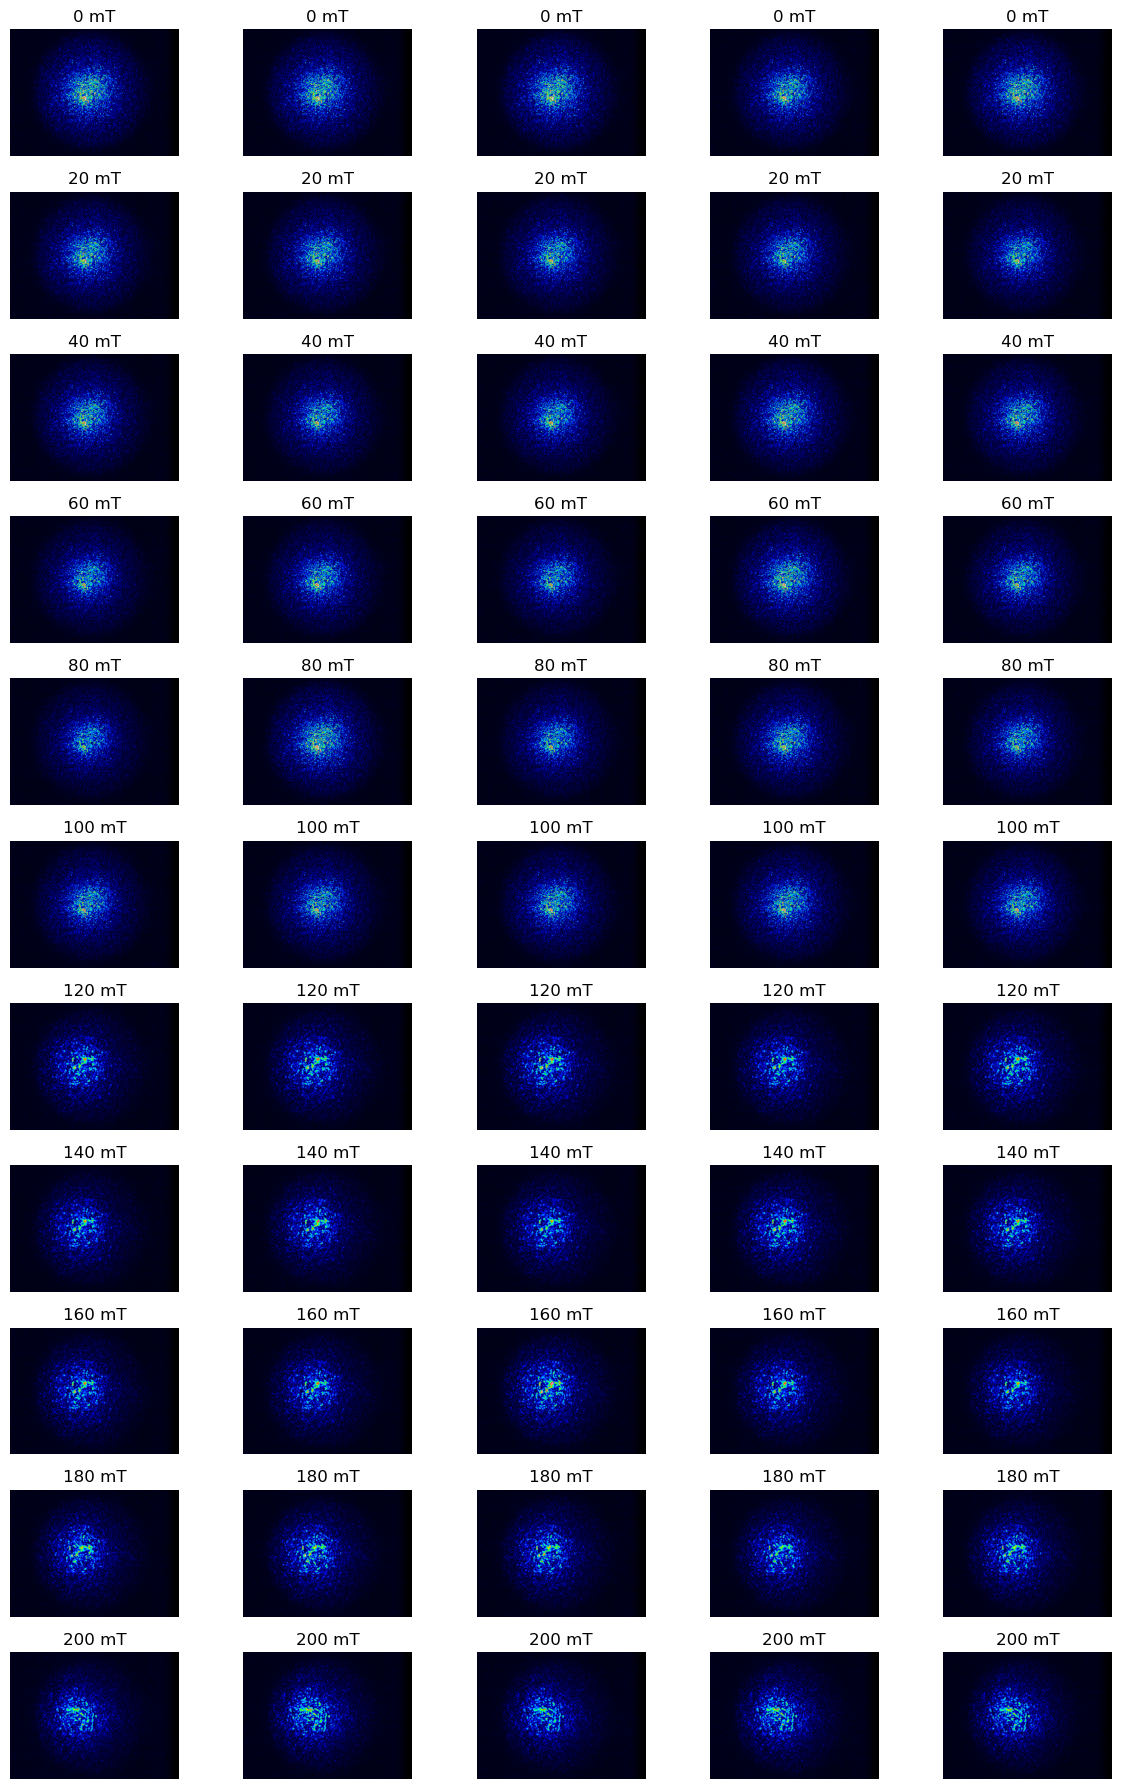

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

base_path = "."
classes = ["0 mT", "20 mT", "40 mT", "60 mT", "80 mT", 
           "100 mT", "120 mT", "140 mT", "160 mT", "180 mT", "200 mT"]

fig, axes = plt.subplots(len(classes), 5, figsize=(12, 18))

for i, class_name in enumerate(classes):
    folder = os.path.join(base_path, class_name)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_images = random.sample(images, 5)
    
    for j, img_name in enumerate(sampled_images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(class_name)

plt.tight_layout()
plt.show()


In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def resize_and_crop(img, target_size):
    target_width, target_height = target_size
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height
    
    if img_ratio > target_ratio:
        new_height = target_height
        new_width = int(new_height * img_ratio)
    else:
        new_width = target_width
        new_height = int(new_width / img_ratio)
    
    img_resized = img.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)
    
    left = (new_width - target_width) // 2
    top = (new_height - target_height) // 2
    right = left + target_width
    bottom = top + target_height
    
    return img_resized.crop((left, top, right, bottom))

base_path = "."
classes = ["0 mT", "20 mT", "40 mT", "60 mT", "80 mT", 
           "100 mT", "120 mT", "140 mT", "160 mT", "180 mT", "200 mT"]
target_size = (128, 128)


data = []
labels = []
for idx, class_name in enumerate(classes):
    folder = os.path.join(base_path, class_name)
    image_files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
    
    for file in image_files:
        img_path = os.path.join(folder, file)
        img = Image.open(img_path)
        img_processed = resize_and_crop(img, target_size)  # Agora a função está definida
        img_array = np.array(img_processed)
        if img_array.ndim == 2:  # Converter grayscale para RGB se necessário
            img_array = np.stack((img_array,)*3, axis=-1)
        data.append(img_array)
        labels.append(idx)

data = np.array(data)
labels = np.array(labels)
data = data / 255.0  

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



def prepare_quadrants(X_data):
    
    n_samples = X_data.shape[0]
    quadrants = np.zeros((n_samples, 4, 64, 64, 3))
    
    for i in range(n_samples):
        img = X_data[i]
        quadrants[i, 0] = img[:64, :64]  # Q1
        quadrants[i, 1] = img[:64, 64:]  # Q2
        quadrants[i, 2] = img[64:, :64]  # Q3
        quadrants[i, 3] = img[64:, 64:]  # Q4
    
    return quadrants

X_train_quad = prepare_quadrants(X_train)
X_val_quad = prepare_quadrants(X_val)
X_test_quad = prepare_quadrants(X_test)

print("Training quadrant shapes:", X_train_quad.shape)

Training quadrant shapes: (7700, 4, 64, 64, 3)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Concatenate

def create_head(input_shape):
    
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    return Model(inputs=input_layer, outputs=x)


input_layer = Input(shape=(128, 128, 3))

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)  # Padding mantém 128x128
x = layers.MaxPooling2D((2,2))(x)  


def split_quadrants(x):
    return [
        x[:, :32, :32, :],  
        x[:, :32, 32:, :],   
        x[:, 32:, :32, :],   
        x[:, 32:, 32:, :]    
    ]

quadrants = Lambda(split_quadrants)(x)


head_models = [create_head((32,32,32)) for _ in range(4)]  
processed_quadrants = [head_models[i](quadrants[i]) for i in range(4)]


merged = Concatenate()(processed_quadrants)

x = layers.Dense(128, activation='relu')(merged)
x = layers.Dropout(0.5)(x)
output = layers.Dense(11, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ [(None, 32, 32, 32),      │               0 │ max_pooling2d[0][0]        │
│                               │ (None, 32, 32, 32),       │                 │                            │
│                               │ (None, 32, 32, 32),       │                 │                            │
│                               │ (None, 32, 32, 32)]       │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4608)              │          92,352 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ (None, 4608)              │          92,352 │ lambda[0][1]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_2 (Functional)     │ (None, 4608)              │          92,352 │ lambda[0][2]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_3 (Functional)     │ (None, 4608)              │          92,352 │ lambda[0][3]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 18432)             │               0 │ functional[0][0],          │
│                               │                           │                 │ functional_1[0][0],        │
│                               │                           │                 │ functional_2[0][0],        │
│                               │                           │                 │ functional_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       2,359,424 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 11)                │           1,419 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,731,147 (10.42 MB)

 Trainable params: 2,731,147 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

##### In the cell below, we use 20 epochs in the original results

Epoch 1/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3332 - loss: 1.7275
Epoch 1: val_loss improved from inf to 0.70518, saving model to best_mhcnn_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 93s 360ms/step - accuracy: 0.3337 - loss: 1.7257 - val_accuracy: 0.7006 - val_loss: 0.7052
Epoch 2/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6545 - loss: 0.7658
Epoch 2: val_loss improved from 0.70518 to 0.46225, saving model to best_mhcnn_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.6546 - loss: 0.7654 - val_accuracy: 0.8121 - val_loss: 0.4622
Epoch 3/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7535 - loss: 0.5430
Epoch 3: val_loss improved from 0.46225 to 0.38842, saving model to best_mhcnn_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.7535 - loss: 0.5429 - val_accuracy: 0.8127 - val_loss: 0.3884
Epoch 4/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7730 - loss: 0.4679
Epoch 4: val_loss improved from 0.38842 to 0.34073, saving model to best_mhcnn_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.7730 - loss: 0.4678 - val_accuracy: 0.8552 - val_loss: 0.3407
Epoch 5/5
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8010 - loss: 0.4151
Epoch 5: val_loss did not improve from 0.34073
241/241 ━━━━━━━━━━━━━━━━━━━━ 78s 325ms/step - accuracy: 0.8010 - loss: 0.4151 - val_accuracy: 0.8242 - val_loss: 0.3484
Restoring model weights from the end of the best epoch: 4.


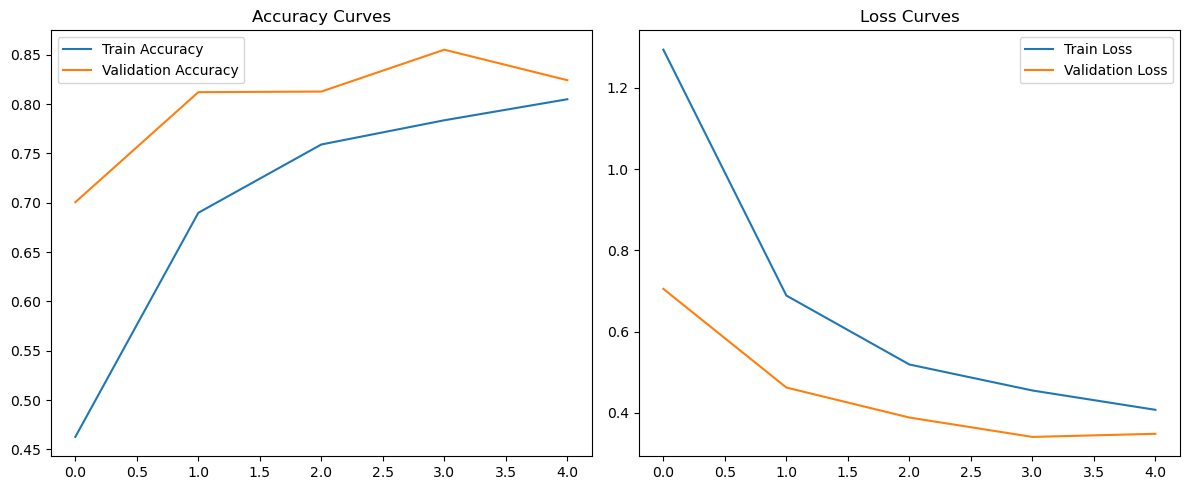

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    "best_mhcnn_model.h5",  
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


history = model.fit(
    X_train, y_train,  
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.savefig('mhcnn_training_curves.png', dpi=300)
plt.show()

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy in test set: {test_acc:.4f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8767 - loss: 0.3180
Accuracy in test set: 0.8642


Report by Class:
              precision    recall  f1-score   support

        0 mT      0.968     1.000     0.984       150
       20 mT      0.993     0.967     0.980       150
       40 mT      0.884     0.913     0.898       150
       60 mT      0.675     0.747     0.709       150
       80 mT      0.675     0.693     0.684       150
      100 mT      0.968     0.800     0.876       150
      120 mT      0.812     0.547     0.653       150
      140 mT      0.647     0.867     0.741       150
      160 mT      0.986     0.973     0.980       150
      180 mT      1.000     1.000     1.000       150
      200 mT      1.000     1.000     1.000       150

    accuracy                          0.864      1650
   macro avg      0.873     0.864     0.864      1650
weighted avg      0.873     0.864     0.864      1650



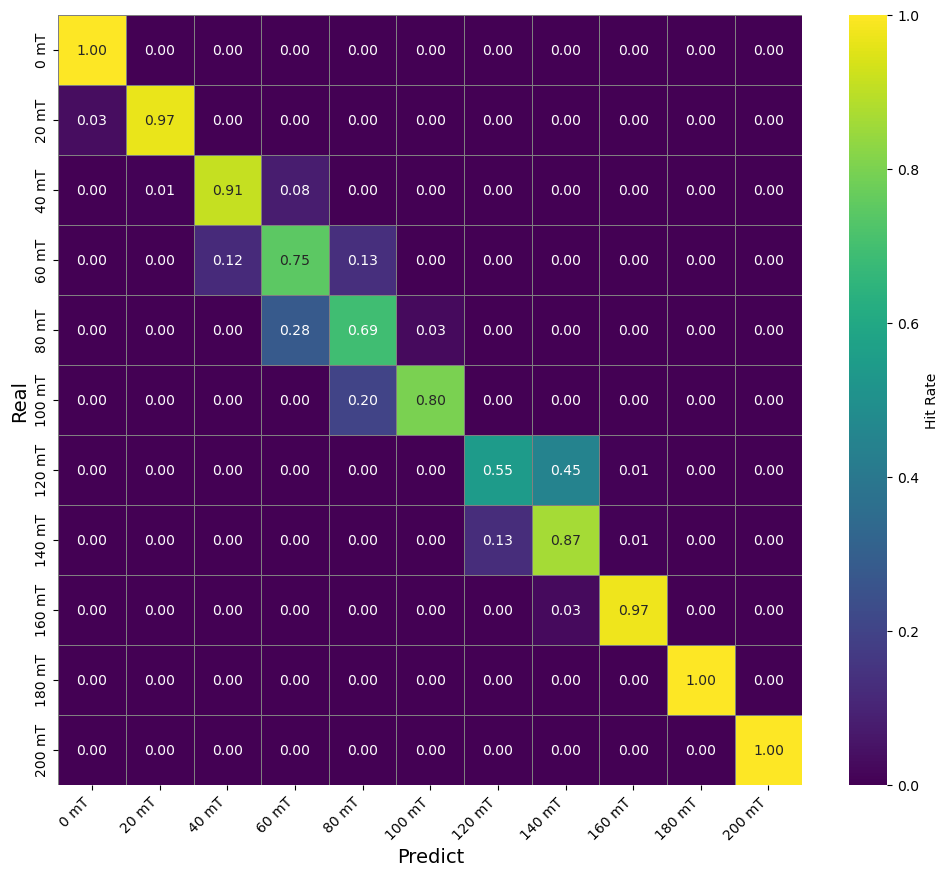

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_norm = (conf_matrix.astype('float') + 1e-6) / (conf_matrix.sum(axis=1, keepdims=True) + 1e-6)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(conf_matrix_norm, 
                 annot=True, 
                 fmt=".2f", 
                 cmap="viridis",  
                 xticklabels=classes, 
                 yticklabels=classes,
                 vmin=0, 
                 vmax=1,
                 linewidths=0.5,  
                 linecolor='gray',
                 cbar_kws={'label': 'Hit Rate', 
                          'ticks': np.linspace(0, 1, 6)})

plt.xlabel("Predict", fontsize=14)
plt.ylabel("Real", fontsize=14)
plt.xticks(rotation=45, ha='right') 


print("Report by Class:")
print(classification_report(y_test, y_pred, target_names=classes, digits=3))


plt.show()